In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("data/AAPL.csv", index_col = 0)
df["Adj Close"] = df.Close # Moving close to the last column
df.drop(['Close'], 1, inplace=True) # Moving close to the last column
df.head()

,High,Low,Open,Volume,Adj Close
Date,,,,,
2010-01-04,30.642857,30.340000,30.490000,123432400.0,30.572857
2010-01-05,30.798571,30.464285,30.657143,150476200.0,30.625713
2010-01-06,30.747143,30.107143,30.625713,138040000.0,30.138571
2010-01-07,30.285715,29.864286,30.250000,119282800.0,30.082857
2010-01-08,30.285715,29.865715,30.042856,111902700.0,30.282858


In [3]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['Volume'] = min_max_scaler.fit_transform(df.Volume.values.reshape(-1,1))
    df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,High,Low,Open,Volume,Adj Close
Date,,,,,
2010-01-04,0.012862,0.015604,0.014799,0.244034,0.015330
2010-01-05,0.013620,0.016218,0.015621,0.302982,0.015589
2010-01-06,0.013370,0.014455,0.015466,0.275875,0.013208
2010-01-07,0.011124,0.013256,0.013618,0.234989,0.012936
2010-01-08,0.011124,0.013263,0.012599,0.218903,0.013913


In [4]:
# Create training set and testing set

def load_data(stock, seq_len):
    features = len(stock.columns) # five features
    data = stock.values
    sequence_length = seq_len+1 # +1 because index starts from 0
    result = []
    # maximum date = latest date - sequence length
    # there is at most 22 trading days in one month
    for index in range(len(data) - sequence_length):
        # index: index + 22 days
        result.append(data[index:index+sequence_length])
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90 percent split
    train = result[:int(row), :] # 90 percent of  date, all features
    
    x_train = train[:, :-1] 
    y_train = train[:,-1][:,-1]
    
    x_test = result[int(row):,:-1] 
    y_test = result[int(row):,-1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], features))  

    return [x_train, y_train, x_test, y_test]

In [5]:
# Build model

def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [6]:
window = 22
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train[0], y_train[0])

[[1.28624937e-02 1.56041766e-02 1.47987840e-02 2.44034312e-01
  1.53304812e-02]
 [1.36203369e-02 1.62176212e-02 1.56209386e-02 3.02982342e-01
  1.55887783e-02]
 [1.33700432e-02 1.44548424e-02 1.54663419e-02 2.75874854e-01
  1.32082264e-02]
 [1.11243252e-02 1.32561491e-02 1.36182554e-02 2.34989328e-01
  1.29359668e-02]
 [1.11243252e-02 1.32632004e-02 1.25993413e-02 2.18902744e-01
  1.39133238e-02]
 [1.18195926e-02 1.28330803e-02 1.43560846e-02 2.26868983e-01
  1.26078571e-02]
 [9.57386525e-03 1.14016940e-02 1.18193493e-02 2.98925222e-01
  1.09393745e-02]
 [1.03803784e-02 9.76582923e-03 1.08917972e-02 3.05155092e-01
  1.29848356e-02]
 [1.00536033e-02 1.32349952e-02 1.24658353e-02 2.10883102e-01
  1.21331411e-02]
 [1.08462108e-02 1.10138817e-02 1.30420407e-02 2.98711609e-01
  9.68975789e-03]
 [1.33422318e-02 1.19798914e-02 1.12150355e-02 3.72789542e-01
  1.60495318e-02]
 [1.35925254e-02 1.35734483e-02 1.58387794e-02 3.08566796e-01
  1.37387924e-02]
 [1.20351219e-02 1.19587375e-02 1.385014

In [7]:
model = build_model([5,window,1])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Compilation Time :  0.059839725494384766


In [8]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 1795 samples, validate on 200 samples
Epoch 1/90
1795/1795 [==============================] - 3s 2ms/step - loss: 0.0810 - acc: 5.5710e-04 - val_loss: 0.1849 - val_acc: 0.0000e+00
Epoch 2/90
1795/1795 [==============================] - 2s 1ms/step - loss: 0.0323 - acc: 5.5710e-04 - val_loss: 0.0361 - val_acc: 0.0000e+00
Epoch 3/90
1795/1795 [==============================] - 2s 990us/step - loss: 0.0130 - acc: 5.5710e-04 - val_loss: 0.1378 - val_acc: 0.0000e+00
Epoch 4/90
1795/1795 [==============================] - 2s 960us/step - loss: 0.0161 - acc: 5.5710e-04 - val_loss: 0.0649 - val_acc: 0.0000e+00
Epoch 5/90
1795/1795 [==============================] - 2s 990us/step - loss: 0.0064 - acc: 5.5710e-04 - val_loss: 0.0321 - val_acc: 0.0000e+00
Epoch 6/90
1795/1795 [==============================] - 2s 944us/step - loss: 0.0074 - acc: 5.5710e-04 - val_loss: 0.0591 - val_acc: 0.0000e+00
Epoch 7/90
1795/1795 [==============================] - 2s 970us/step - loss: 0.0041 - acc: 5

1795/1795 [==============================] - 2s 957us/step - loss: 4.2164e-04 - acc: 5.5710e-04 - val_loss: 4.9196e-04 - val_acc: 0.0000e+00
Epoch 57/90
1795/1795 [==============================] - 2s 1ms/step - loss: 4.5655e-04 - acc: 5.5710e-04 - val_loss: 9.8186e-04 - val_acc: 0.0000e+00
Epoch 58/90
1795/1795 [==============================] - 2s 983us/step - loss: 4.2080e-04 - acc: 5.5710e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 59/90
1795/1795 [==============================] - 2s 978us/step - loss: 4.3468e-04 - acc: 5.5710e-04 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 60/90
1795/1795 [==============================] - 2s 977us/step - loss: 4.3663e-04 - acc: 5.5710e-04 - val_loss: 6.9795e-04 - val_acc: 0.0000e+00
Epoch 61/90
1795/1795 [==============================] - 2s 956us/step - loss: 4.1528e-04 - acc: 5.5710e-04 - val_loss: 6.8117e-04 - val_acc: 0.0000e+00
Epoch 62/90
1795/1795 [==============================] - 2s 979us/step - loss: 3.9900e-04 - acc: 5.5710e

In [9]:
diff=[]
ratio=[]
p = model.predict(X_test)
# for each data index in test data
for i in range(len(y_test)):
    # pr = prediction day i
    pr = p[i][0]

In [10]:
df = pd.read_csv("data/AAPL.csv", index_col = 0)
df["Adj Close"] = df.Close # Moving close to the last column
df.drop(['Close'], 1, inplace=True) # Moving close to the last column

# Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [11]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00024 MSE (0.02 RMSE)
Test Score: 0.00192 MSE (0.04 RMSE)


(0.00023538000260352537, 0.001917104511563708)

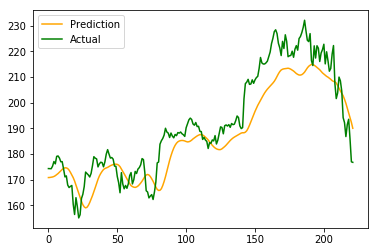

In [12]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='orange', label='Prediction')
plt2.plot(newy_test,color='green', label='Actual')
plt2.legend(loc='best')
plt2.show()